In [3]:
import uproot
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.constants import epsilon_0, e as q_e
import glob

import trimesh

from common_functions import *

# Loop over all iterations 

[-9.61651984e-07  8.91095517e-07  1.35715769e-07]


/tmp/ipykernel_3931010/199066652.py:15: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  slice_2D, to_3D = section.to_planar()


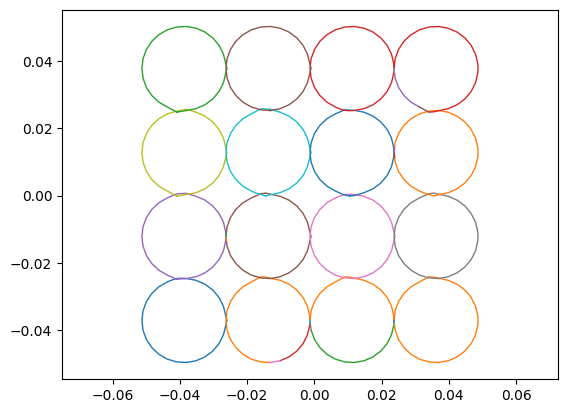

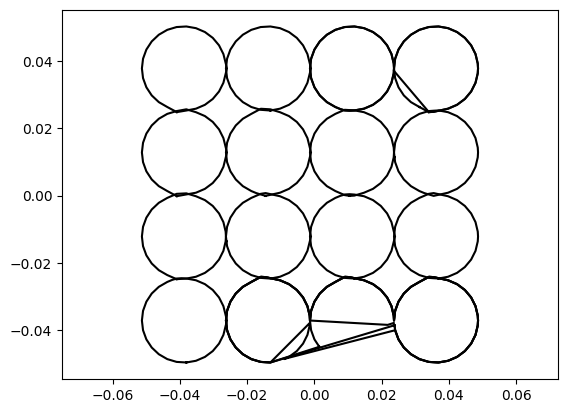

In [4]:
stacked_spheres = trimesh.load_mesh('../sphere-charging/geometry/stacked_spheres.stl') 
# # Suppose your mesh is in millimeters, and you want to convert to meters:
stacked_spheres.apply_scale(1e-3) # 1 mm = 0.001 meters

meshes = stacked_spheres.split(only_watertight=False)
# the convex hull of every component
meshes_convex = [i.convex_hull for i in meshes if i.vertices.shape[0] > 300]

# combine all components into one mesh
convex_combined = np.sum(meshes_convex)

# get a single cross section of the mesh
section = convex_combined.section(plane_origin=stacked_spheres.centroid, plane_normal=[0, 0, 1])
print(convex_combined.centroid)
slice_2D, to_3D = section.to_planar()

# if we want to intersect a line with this 2D polygon, we can use shapely methods
polygons = slice_2D.polygons_full

slice_2D.show()
plt.figure()
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y, 'k-')
plt.axis('equal')
plt.show()


In [5]:
directory_path = "/storage/coda1/p-zjiang33/0/shared/avira7/root_files/stacked-sphere/output091425"
filelist = sorted(glob.glob(f"{directory_path}/*_num10000.root"))

# Load ASCII STL file
#stacked_spheres = mesh.Mesh.from_file('../sphere-charging/geometry/stacked_spheres.stl')  # Replace with your STL path
#stacked_spheres.vectors *= 1e-3  # Scale down by 1e-3

# stacked_spheres = trimesh.load_mesh('../sphere-charging/geometry/stacked_spheres.stl') 
# # # Suppose your mesh is in millimeters, and you want to convert to meters:
# stacked_spheres.apply_scale(1e-3) # 1 mm = 0.001 meters

# # stacked_spheres = trimesh.load_mesh('../sphere-charging/geometry/stacked_spheres_frompython.stl') 
# # scale = 1e-1
# # stacked_spheres.apply_scale(scale)

# section = stacked_spheres.section(plane_origin=(0,0,0), plane_normal=[1, 0, 1])
# slice_2D, to_3D = section.to_2D()

for fileIN in filelist:
    
    print(fileIN.split("/")[-1])
    number_str = fileIN.split("/")[-1].split("_")[1]
    iterationNUM = int(''.join(filter(str.isdigit, number_str)))

    # read data from different iterations
    dfIN = read_rootfile(fileIN.split("/")[-1], directory_path = directory_path)
    vars()["electrons_inside_"+str(iterationNUM)], vars()["protons_inside_"+str(iterationNUM)] = calculate_stats(dfIN)

    # plot the end location of all the stopped electrons inside the spheres
    #plot_electron_positions(electrons_inside, world_dimensions = (-0.05, 0.05), n_bins=50,stacked_spheres=stacked_spheres,iteration="e-: iteration"+str(iterationNUM))
    #plot_electron_positions(protons_inside, world_dimensions = (-0.05, 0.05), n_bins=50,stacked_spheres=stacked_spheres,iteration="iteration"+str(iterationNUM))
    #plot_positions_slice(electrons_inside, protons_inside, stacked_spheres=slice_2D,iteration="iteration"+str(iterationNUM),plane="zy")
    #plot_positions_slice(electrons_inside, protons_inside, stacked_spheres=slice_2D,iteration="iteration"+str(iterationNUM),plane="zx")

    print(78*"-")
    del dfIN, number_str

    if iterationNUM > 7:
        break

# still need to fix the potential calculation on the stacked spheres
#plot_potential_on_sphere(electrons_inside_iteration0, vmin=-0.05, vmax=0, iteration="iteration0")

00_stackediteration0_num10000.root
Photoelectric yield (e⁻ / γ): 0.4525 (4009 / 8859)
Protons captured in material: 72.50% (58 / 80)
Electrons captured in material: 100.00% (102 / 102)

------------------------------------------------------------------------------
01_stackediteration1_from_00_num10000.root
Photoelectric yield (e⁻ / γ): 0.4565 (4044 / 8858)
Protons captured in material: 78.46% (51 / 65)
Electrons captured in material: 100.00% (84 / 84)

------------------------------------------------------------------------------
02_stackediteration2_from_00_num10000.root
Photoelectric yield (e⁻ / γ): 0.4516 (4008 / 8875)
Protons captured in material: 86.76% (59 / 68)
Electrons captured in material: 100.00% (87 / 87)

------------------------------------------------------------------------------
03_stackediteration3_from_00_num10000.root
Photoelectric yield (e⁻ / γ): 0.4506 (3990 / 8854)
Protons captured in material: 77.46% (55 / 71)
Electrons captured in material: 100.00% (87 / 87)

-

In [ ]:
def plot_surface_potential(electrons, protons, convex_combined, vmin=-0.01,vmax=0.01):


    point = np.array(electrons["Pre_Step_Position_mm"].tolist())  # Your point coordinate
    _, distance_e, face_id_e = convex_combined.nearest.on_surface(point)

    # Compute potential at each surface point due to each electron
    q = -1.602e-19  # electron charge in Coulombs
    potentials_e = 1 / (4 * np.pi * epsilon_0) * q / (distance_e + 1e-12)  # result is an array of potentials

    point = np.array(protons["Pre_Step_Position_mm"].tolist())  # Your point coordinate
    _, distance_p, face_id_p = convex_combined.nearest.on_surface(point)

    # Compute potential at each surface point due to each electron
    q = +1.602e-19  # electron charge in Coulombs
    potentials_p = 1 / (4 * np.pi * epsilon_0) * q / (distance_p + 1e-12)  # result is an array of potentials

    # --- Electrons ---

    # Find unique face IDs and inverse indices for electrons
    unique_faces_e, inverse_indices_e = np.unique(face_id_e, return_inverse=True)

    # Initialize array to sum potentials for each unique face (electrons)
    potentials_sum_e = np.zeros(len(unique_faces_e))

    # Accumulate potentials for each face using inverse indices
    np.add.at(potentials_sum_e, inverse_indices_e, potentials_e)

    # --- Protons ---

    # Find unique face IDs and inverse indices for protons
    unique_faces_p, inverse_indices_p = np.unique(face_id_p, return_inverse=True)

    # Initialize array to sum potentials for each unique face (protons)
    potentials_sum_p = np.zeros(len(unique_faces_p))

    # Accumulate potentials for each face using inverse indices
    np.add.at(potentials_sum_p, inverse_indices_p, potentials_p)

    # --- Combine electron and proton potentials per face ---

    # Initialize full array for face potentials (length = total number of faces)
    face_potentials = np.zeros(len(convex_combined.faces))

    # Add electron potentials to their respective faces
    face_potentials[unique_faces_e] += potentials_sum_e

    # Add proton potentials to their respective faces (accumulate)
    face_potentials[unique_faces_p] += potentials_sum_p

    # Prepare RGBA array initialized to transparent
    colors_rgba = np.zeros((len(face_potentials), 4), dtype=np.uint8)

    # Normalize only non-zero potentials
    norm = np.zeros_like(face_potentials)
    norm = (face_potentials - vmin) / (vmax - vmin)
    norm = np.clip(norm, 0, 1)

    # Map normalized potentials to RGB
    cmap = plt.cm.seismic
    colors_rgb = cmap(norm)[:, :3]

    # Assign RGB to all faces
    colors_rgba[:, :3] = (colors_rgb * 255).astype(np.uint8)

    # Apply colors to mesh
    convex_combined.visual.face_colors = colors_rgba

    return convex_combined

In [7]:
print("iteration0")
iteration0_surface = plot_surface_potential(electrons_inside_0, protons_inside_0, convex_combined, vmin=-0.01,vmax=0.01)
iteration0_surface.show()

iteration0


In [8]:
print("iteration4")
iteration0_surface = plot_surface_potential(electrons_inside_4, protons_inside_4, convex_combined, vmin=-0.01,vmax=0.01)
iteration0_surface.show()

iteration4


In [ ]:
print("iteration9")
iteration0_surface = plot_surface_potential(electrons_inside_8, protons_inside_8, convex_combined, vmin=-0.01,vmax=0.01)
iteration0_surface.show()

iteration9


: 

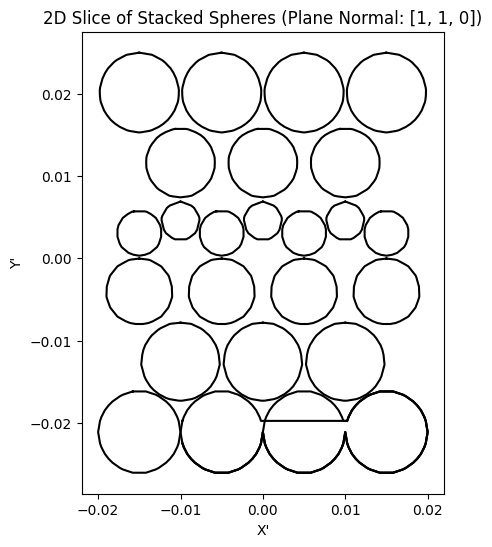

In [11]:
stacked_spheres = trimesh.load_mesh('../sphere-charging/geometry/stacked_spheres_frompython.stl') 
stacked_spheres.apply_scale(0.1)
section = stacked_spheres.section(plane_origin=(0,0,0), plane_normal=[1, 0, 1])
slice_2D, to_3D = section.to_2D()


# Plotting the 2D slice
fig, ax = plt.subplots(figsize=(6, 6))

for contour in slice_2D.discrete:
    ax.plot(contour[:, 1], contour[:, 0], 'k-')  # black solid line

ax.set_aspect('equal')
ax.set_title("2D Slice of Stacked Spheres (Plane Normal: [1, 1, 0])")
ax.set_xlabel("X'")
ax.set_ylabel("Y'")
plt.show()


[-9.61651984e-07  8.91095517e-07  1.35715769e-07]


/tmp/ipykernel_3462752/13598622.py:11: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  slice_2D, to_3D = section.to_planar()


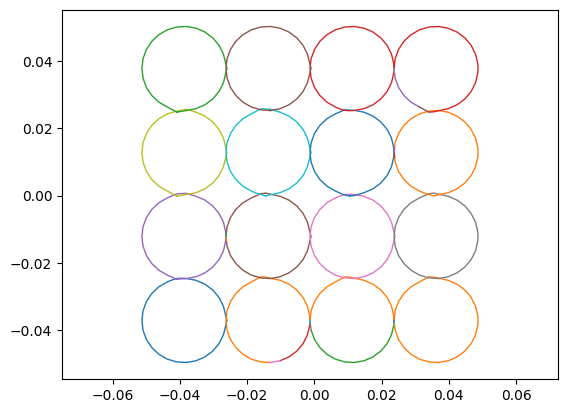

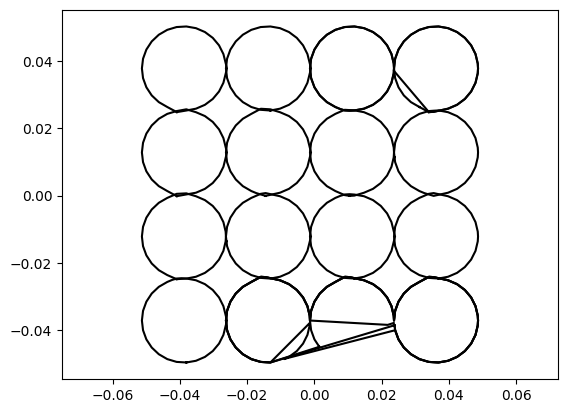

In [4]:
meshes = stacked_spheres.split(only_watertight=False)
# the convex hull of every component
meshes_convex = [i.convex_hull for i in meshes if i.vertices.shape[0] > 300]

# combine all components into one mesh
convex_combined = np.sum(meshes_convex)

# get a single cross section of the mesh
section = convex_combined.section(plane_origin=stacked_spheres.centroid, plane_normal=[0, 0, 1])
print(convex_combined.centroid)
slice_2D, to_3D = section.to_planar()

# if we want to intersect a line with this 2D polygon, we can use shapely methods
polygons = slice_2D.polygons_full

slice_2D.show()
plt.figure()
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y, 'k-')
plt.axis('equal')
plt.show()


# Iteration 0

Photoelectric yield (number of photoelectrons / number of incident gammas):  0.5308963331824355
Percentage of protons captured in material:  0.9782608695652174 ,# protons stopped:  45 ,# protons incident:  46
Percentage of e- captured in material:  1.0


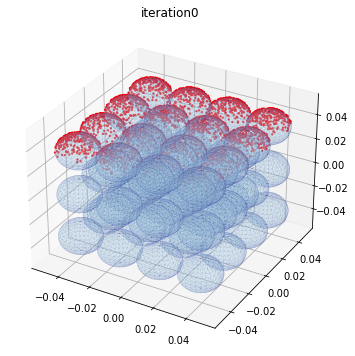

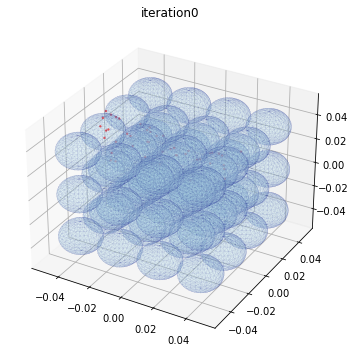

(<Figure size 576x432 with 1 Axes>,
 <Axes3DSubplot:title={'center':'iteration0'}>)

In [27]:
# read data from different iterations
df_iteration0 = read_rootfile("00_stackediteration0_num10000.root", directory_path = "/storage/coda1/p-zjiang33/0/shared/avira7/root_files/stacked-sphere")
electrons_inside_iteration0, protons_inside_iteration0 = calculate_stats(df_iteration0)

# Load ASCII STL file
stacked_spheres = mesh.Mesh.from_file('../sphere-charging/geometry/stacked_spheres.stl')  # Replace with your STL path
stacked_spheres.vectors *= 1e-3  # Scale down by 1e-3

# plot the end location of all the stopped electrons inside the spheres
plot_electron_positions(electrons_inside_iteration0, world_dimensions = (-0.05, 0.05), n_bins=50,stacked_spheres=stacked_spheres)
plot_electron_positions(protons_inside_iteration0, world_dimensions = (-0.05, 0.05), n_bins=50,stacked_spheres=stacked_spheres)

# still need to fix the potential calculation on the stacked spheres
#plot_potential_on_sphere(electrons_inside_iteration0, vmin=-0.05, vmax=0, iteration="iteration0")

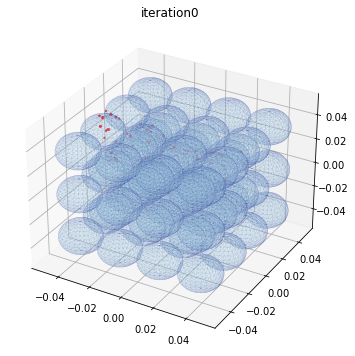

(<Figure size 576x432 with 1 Axes>,
 <Axes3DSubplot:title={'center':'iteration0'}>)

In [ ]:
# plot the end location of all the stopped electrons inside the spheres
plot_electron_positions(df_iteration0[df_iteration0["Particle_Type"]=="proton"], world_dimensions = (-0.05, 0.05), n_bins=50,stacked_spheres=stacked_spheres,iteration="iteration0")

In [25]:
dfIN[dfIN["Particle_Type"]=="proton"] #.drop_duplicates(subset="Event_Number", keep="last")

Event_Number Process_Name_Pre Process_Name_Post Particle_Type  \
548              137              NaN             hIoni        proton   
22954            941   Transportation               msc        proton   
22955            941              msc               msc        proton   
22956            941              msc               msc        proton   
22957            941              msc               msc        proton   
...              ...              ...               ...           ...   
134418          9158              msc               msc        proton   
134419          9158              msc               msc        proton   
134420          9158              msc             hIoni        proton   
134972          9471              NaN             hIoni        proton   
135577          9808              NaN             hIoni        proton   

           Volume_Name_Pre    Volume_Name_Post  Kinetic_Energy_Pre_MeV  \
548     G4_SILICON_DIOXIDE  G4_SILICON_DIOXIDE                0.001000   
22954   G4_SILICON_DIOXIDE  G4_SILICON_DIOXIDE                0.001000   
22955   G4_SILICON_DIOXIDE  G4_SILICON_DIOXIDE                0.000358   
22956   G4_SILICON_DIOXIDE  G4_SILICON_DIOXIDE                0.000301   
22957   G4_SILICON_DIOXIDE  G4_SILICON_DIOXIDE                0.000043   
...                    ...                 ...                     ...   
134418  G4_SILICON_DIOXIDE  G4_SILICON_DIOXIDE                0.000041   
134419  G4_SILICON_DIOXIDE  G4_SILICON_DIOXIDE                0.000022   
134420  G4_SILICON_DIOXIDE  G4_SILICON_DIOXIDE                0.000002   
134972  G4_SILICON_DIOXIDE  G4_SILICON_DIOXIDE                0.001000   
135577  G4_SILICON_DIOXIDE  G4_SILICON_DIOXIDE                0.001000   

        Kinetic_Energy_Post_MeV  Parent_ID  \
548                    0.000000        0.0   
22954                  0.000358        0.0   
22955                  0.000301        0.0   
22956                  0.000043        0.0   
22957                  0.000023        0.0   
...                         ...        ...   
134418                 0.000022        0.0   
134419                 0.000002        0.0   
134420                 0.000000        0.0   
134972                 0.000000        0.0   
135577                 0.000000        0.0   

                                     Pre_Step_Position_mm  \
548     [0.0015843748401640906, 0.0, 0.02395223300428865]   
22954   [0.039491182397041046, -0.0052478329848055175,...   
22955   [0.03949393568625747, -0.0052494740132027675, ...   
22956   [0.03949390957142588, -0.00524970004385062, 0....   
22957   [0.039493830515000716, -0.005249524759304195, ...   
...                                                   ...   
134418  [0.027395699539490077, -0.012780193239627556, ...   
134419  [0.02739570778391505, -0.012780192911211328, 0...   
134420  [0.02739570914727701, -0.012780191735635972, 0...   
134972  [-0.005787583948114239, 0.0, 0.015320258774190...   
135577   [0.03194852063350982, 0.0, 0.023236552222592265]   

                                    Post_Step_Position_mm  \
548     [0.0015854853791038685, -1.1105389411251638e-0...   
22954   [0.03949393568625747, -0.0052494740132027675, ...   
22955   [0.03949390957142588, -0.00524970004385062, 0....   
22956   [0.039493830515000716, -0.005249524759304195, ...   
22957   [0.039493828814124526, -0.005249534724416652, ...   
...                                                   ...   
134418  [0.02739570778391505, -0.012780192911211328, 0...   
134419  [0.02739570914727701, -0.012780191735635972, 0...   
134420  [0.02739661541640067, -0.012778203544859269, 0...   
134972  [-0.00578647340917308, -1.1105389397443102e-06...   
135577  [0.03194963117244609, -1.1105389446305654e-06,...   

        Kinetic_Energy_Diff_eV  
548                1000.000000  
22954               641.658850  
22955                57.275717  
22956               258.420738  
22957                19.573180  
...                      

# Iteration 1

Photoelectric yield (number of photoelectrons / number of incident gammas):  0.5295184135977337
Percentage of protons captured in material:  3.857142857142857 135 35
Percentage of e- captured in material:  1.0


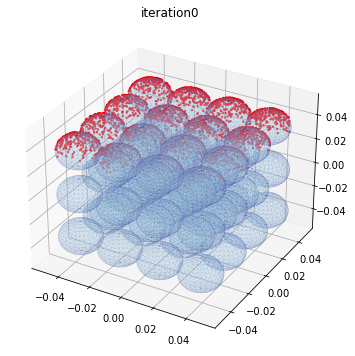

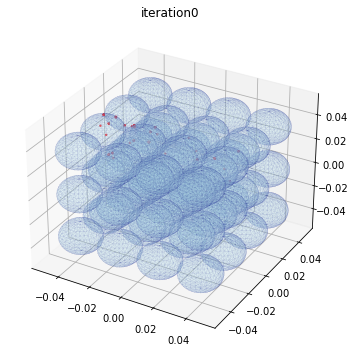

(<Figure size 576x432 with 1 Axes>,
 <Axes3DSubplot:title={'center':'iteration0'}>)

In [ ]:
# read data from different iterations
df_iteration1 = read_rootfile("01_stackediteration1_from_00_num10000.root", directory_path = "/storage/coda1/p-zjiang33/0/shared/avira7/root_files/stacked-sphere")
electrons_inside_iteration1, protons_inside_iteration1 = calculate_stats(df_iteration1)

# Load ASCII STL file
stacked_spheres = mesh.Mesh.from_file('../sphere-charging/geometry/stacked_spheres.stl')  # Replace with your STL path
stacked_spheres.vectors *= 1e-3  # Scale down by 1e-3

# plot the end location of all the stopped electrons inside the spheres
plot_electron_positions(electrons_inside_iteration1, world_dimensions = (-0.05, 0.05), n_bins=50,stacked_spheres=stacked_spheres,iteration="iteration1")
plot_electron_positions(protons_inside_iteration1, world_dimensions = (-0.05, 0.05), n_bins=50,stacked_spheres=stacked_spheres,iteration="iteration1")

# still need to fix the potential calculation on the stacked spheres
#plot_potential_on_sphere(electrons_inside_iteration0, vmin=-0.05, vmax=0, iteration="iteration0")

/tmp/ipykernel_3052041/3513159670.py:59: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  sc = ax.scatter(x,y,z, s=2, norm=LogNorm(vmin=1, vmax=5), alpha=0.8,color="red")


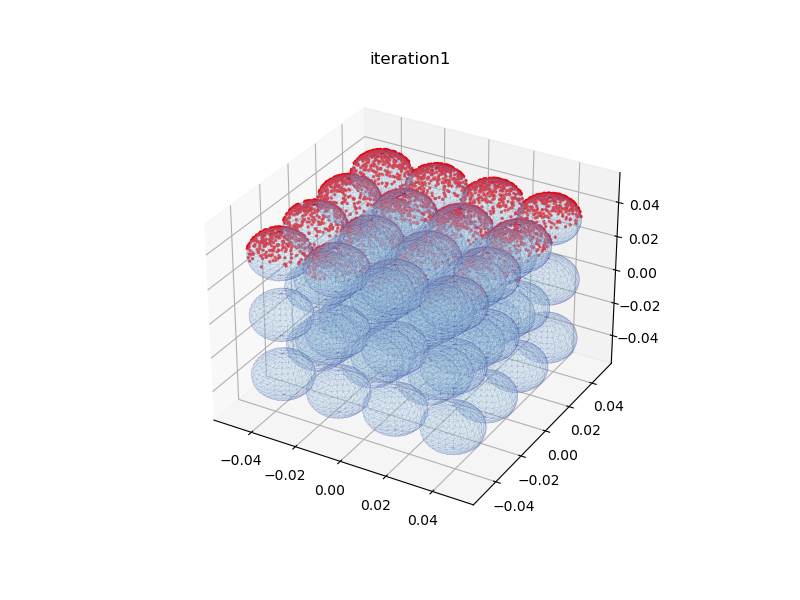

(<Figure size 800x600 with 1 Axes>, <Axes3D: title={'center': 'iteration1'}>)

In [11]:
# read data from different iterations
_, electrons_inside_iteration1 = read_rootfile("01_stackediteration1_from_00_num20000.root")

plot_electron_positions(electrons_inside_iteration1, world_dimensions = (-0.05, 0.05), n_bins=10,iteration="iteration1",stacked_spheres=stacked_spheres)
#plot_potential_on_sphere(electrons_inside_iteration1, vmin=-0.05, vmax=0, iteration="iteration1")


# Iteration 2

/tmp/ipykernel_3052041/4242052674.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  sc = ax.scatter(x,y,z, s=2, norm=LogNorm(vmin=1, vmax=5), alpha=0.8,color="red")


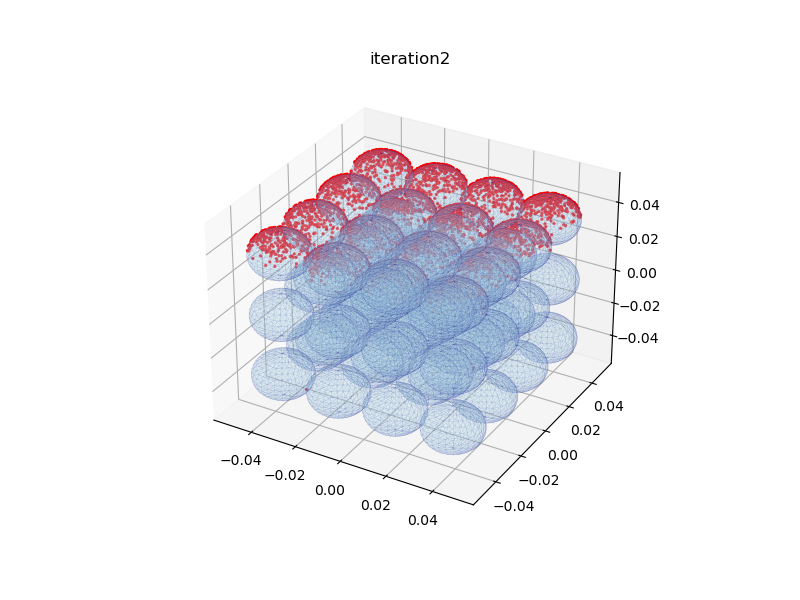

(<Figure size 800x600 with 1 Axes>, <Axes3D: title={'center': 'iteration2'}>)

In [21]:
# read data from different iterations
_, electrons_inside_iteration2 = read_rootfile("02_stackediteration2_from_00_num20000.root")

plot_electron_positions(electrons_inside_iteration2, world_dimensions = (-0.05, 0.05), n_bins=10,iteration="iteration2",stacked_spheres=stacked_spheres)
#plot_potential_on_sphere(electrons_inside_iteration2, vmin=-0.05, vmax=0, iteration="iteration1")

-0.08594587445899839 -0.005945619568130005


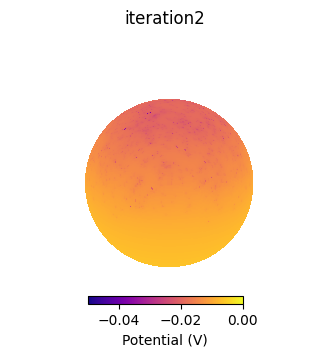

(<Figure size 400x600 with 2 Axes>, <Axes3D: title={'center': 'iteration2'}>)

In [35]:
# read data from different iterations
_, electrons_inside_iteration2 = read_rootfile("02_iteration2_from_00_num5000.root")

#plot_electron_positions(electrons_inside_iteration2, world_dimensions = (-0.05, 0.05), n_bins=100)
plot_potential_on_sphere(electrons_inside_iteration2, vmin=-0.05, vmax=0, iteration="iteration2")


# Iteration 3

/tmp/ipykernel_3052041/3513159670.py:59: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  sc = ax.scatter(x,y,z, s=2, norm=LogNorm(vmin=1, vmax=5), alpha=0.8,color="red")


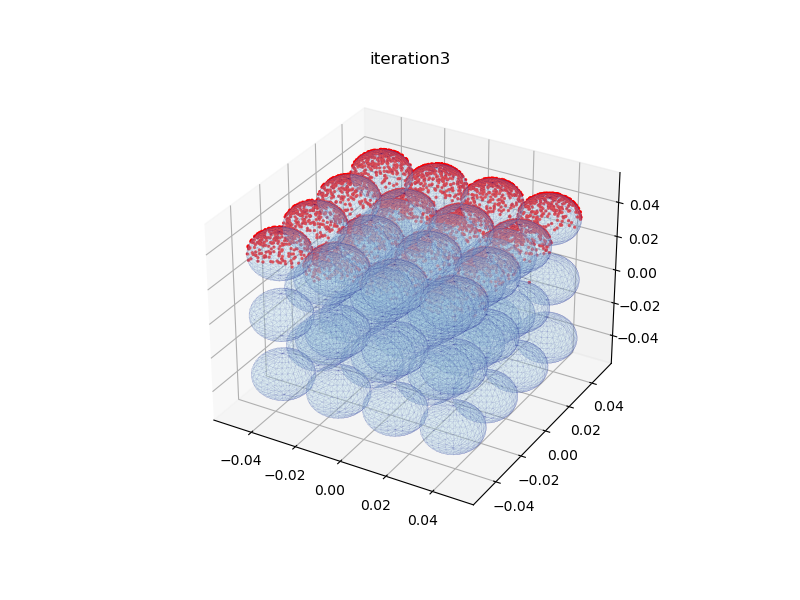

(<Figure size 800x600 with 1 Axes>, <Axes3D: title={'center': 'iteration3'}>)

In [8]:
# read data from different iterations
_, electrons_inside_iteration3 = read_rootfile("03_stackediteration3_from_00_num20000.root")

plot_electron_positions(electrons_inside_iteration3, world_dimensions = (-0.05, 0.05), n_bins=10,iteration="iteration3",stacked_spheres=stacked_spheres)
#plot_potential_on_sphere(electrons_inside_iteration2, vmin=-0.05, vmax=0, iteration="iteration1")

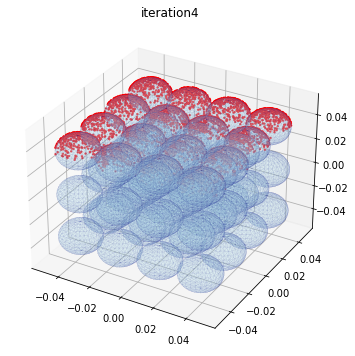

(<Figure size 576x432 with 1 Axes>,
 <Axes3DSubplot:title={'center':'iteration4'}>)

In [12]:
# read data from different iterations
_, electrons_inside_iteration4 = read_rootfile("04_stackediteration4_from_00_num20000.root")

plot_electron_positions(electrons_inside_iteration4, world_dimensions = (-0.05, 0.05), n_bins=10,iteration="iteration4",stacked_spheres=stacked_spheres)
#plot_potential_on_sphere(electrons_inside_iteration2, vmin=-0.05, vmax=0, iteration="iteration1")

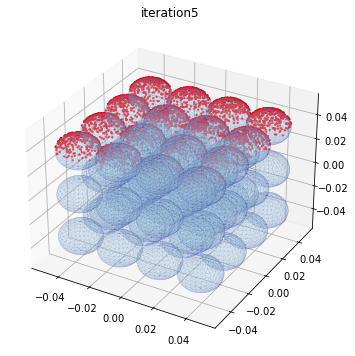

(<Figure size 576x432 with 1 Axes>,
 <Axes3DSubplot:title={'center':'iteration5'}>)

In [11]:
# read data from different iterations
_, electrons_inside_iteration5 = read_rootfile("05_stackediteration5_from_00_num20000.root")

plot_electron_positions(electrons_inside_iteration5, world_dimensions = (-0.05, 0.05), n_bins=10,iteration="iteration5",stacked_spheres=stacked_spheres)
#plot_potential_on_sphere(electrons_inside_iteration2, vmin=-0.05, vmax=0, iteration="iteration1")

-0.06079495675658088 -0.005620294496455831


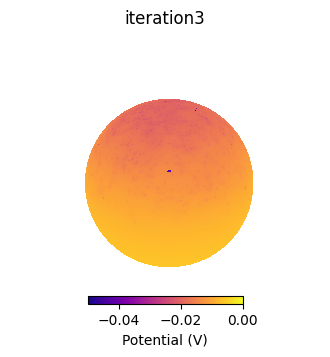

(<Figure size 400x600 with 2 Axes>, <Axes3D: title={'center': 'iteration3'}>)

In [36]:
# read data from different iterations
_, electrons_inside_iteration3 = read_rootfile("03_iteration3_from_00_num5000.root")

#plot_electron_positions(electrons_inside_iteration3, world_dimensions = (-0.05, 0.05), n_bins=100)
plot_potential_on_sphere(electrons_inside_iteration3, vmin=-0.05, vmax=0, iteration="iteration3")


In [ ]:
# ATTEMPTS TO MAKE THE CODE WORK FOR CARTESTIAN COORDINATES

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.constants import epsilon_0, e as q_e
# from matplotlib.colors import LogNorm

# # ----------------------------
# # 1. Electron positions
# # ----------------------------
# coords_m = np.vstack(np.array(electrons_inside_iteration0["Post_Step_Position_mm"])) * 1e-3  # mm to m

# # ----------------------------
# # 2. Define histogram grid
# # ----------------------------

# # Define voxel edges
# n_bins = 100
# world_dimensions = np.array([-0.05, 0.05])*1e-3  # convert mm to m
# x_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
# y_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
# z_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)

# # Compute voxel centers
# x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
# y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
# z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])
# X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

# voxel_centers = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))  # shape (N_voxels, 3)

# # ----------------------------
# # 3. Compute Electric Potential at Voxel Centers
# # ----------------------------
# K = 1.0 / (4.0 * np.pi * epsilon_0 * 3.9)  # SiO2 relative permittivity
# q = -q_e  # charge of an electron

# V_grid = np.zeros(voxel_centers.shape[0])

# for i, p in enumerate(voxel_centers):
#     r_vec = coords_m - p
#     r = np.linalg.norm(r_vec, axis=1)
#     V_grid[i] = K * q * np.sum(1.0 / r)

# V_grid_reshaped = V_grid.reshape(X.shape)  # same shape as the histogram

# # ----------------------------
# # 5. Plot Energy Loss with Potential Overlay (Optional)
# # ----------------------------
# # Mask nonzero energy loss
# mask = V_grid_reshaped > 0
# Xf = X[mask]
# Yf = Y[mask]
# Zf = Z[mask]
# V_values = V_grid_reshaped[mask]

# # Plot energy loss as 3D scatter with potential as color map
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection="3d")

# sc = ax.scatter(
#     Xf * 1e3, Yf * 1e3, Zf * 1e3,  # convert to mm
#     s=2,
#     c=V_values,
#     cmap='plasma',
#     norm=plt.Normalize(vmin=V_grid_reshaped.min(), vmax=V_grid_reshaped.max()),
#     alpha=0.9
# )

# cbar = plt.colorbar(sc, ax=ax, shrink=0.6, label='Electric Potential (V)')
# plt.tight_layout()
# plt.show()
